<a href="https://colab.research.google.com/github/zaidalyafeai/Notebooks/blob/master/BigGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Imports

In [0]:
from IPython import display
import numpy as np
from scipy.stats import truncnorm
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from numpy import linalg as LA

# Load a BigGAN

Download and load the BigGan model using TF Hub

In [0]:
tf.reset_default_graph()
module_path = 'https://tfhub.dev/deepmind/biggan-256/1'
module = hub.Module(module_path)

Check the inputs and outputs of the model

In [24]:
inputs = {k: tf.placeholder(v.dtype, v.get_shape().as_list(), k)
          for k, v in module.get_input_info_dict().iteritems()}
output = module(inputs)

print
print 'Inputs:\n', '\n'.join(
    '  {}: {}'.format(*kv) for kv in inputs.iteritems())
print
print 'Output:', output

INFO:tensorflow:Saver not created because there are no variables in the graph to restore

Inputs:
  y: Tensor("y:0", shape=(?, 1000), dtype=float32)
  z: Tensor("z:0", shape=(?, 140), dtype=float32)
  truncation: Tensor("truncation:0", shape=(), dtype=float32)

Output: Tensor("module_apply_default/G_trunc_output:0", shape=(?, 256, 256, 3), dtype=float32)


We conclude that the BigGan model takes three inputs. **z** which defines the z vector in the latent space. It has a shape 140. The second input **y** is the cateogry which is a one-hot encoded version of the indices from (0, 9999). The last input is **truncation trick**  is, in a way, a method for automatically filtering down to the "best" samples the model

# Hypersphere  Interpolation

For each iteration $i \in (0, N-1)$

$$ z = v_1 + \left( v_2 \frac{\Vert v_1 \Vert }{\Vert v_2 \Vert}  - v_1\right) \times \frac{i}{N-1}$$

Then update $z$ as 

$$\hat{z} =  \Vert v_1 \Vert \times \frac{z}{\Vert z \Vert}$$


In [0]:
def interpolate_hypersphere(v1, v2, num_steps):
  v1_norm = LA.norm(v1)
  v2_norm = LA.norm(v2)
  v2_normalized = v2 * (v1_norm / v2_norm)

  vectors = []
  for step in range(num_steps):
    interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
    interpolated_norm =  LA.norm(interpolated)
    interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
    vectors.append(interpolated_normalized)
  return np.array(vectors)

def get_zy(index, seed = None):
  yA = one_hot(index)
  zA = truncnorm.rvs(-2, 2, size=(1, z_dim), random_state = np.random.RandomState(seed))
  return zA, yA

#helper functions to generate the encoding
def one_hot(index, vocab_size=1000):
  index = np.asarray(index)
  if len(index.shape) == 0:
    index = np.asarray([index])
  assert len(index.shape) == 1
  num = index.shape[0]
  output = np.zeros((num, vocab_size), dtype=np.float32)
  output[np.arange(num), index] = 1
  return output

# Run the Model 

In [0]:
n_labels = 1000 #BigGan is trained on 1000 lables 
z_dim = 140 # the z vector dimension 
num_interps = 20 # the number of interpolations between each two consectuve images
num_interps_images = 5 #the number of images 
r = 207 #the class to interpolate images from  

In [0]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  images = []
  
  #initial interpolation
  zA, yA = get_zy(r)
  izA, iyA = zA, yA 
  
  for i in range(0, num_interps_images):
    
    #use the first interpolation once we reach the last image to create a loop effect
    if i == num_interps_images - 1:
      zB, yB = izA, iyA
    else:
      zB, yB = get_zy(r)

    #create interpolation for both the category and the z vector 
    interps_z = interpolate_hypersphere(zA, zB, num_interps)
    interps_y = interpolate_hypersphere(yA, yB, num_interps)

    #create an image for each interpolation 
    for i in range(0, len(interps_z)):
      feed_dict = {inputs['z']: interps_z[i], inputs['y']:interps_y[i], inputs['truncation']: 0.3}
      im = sess.run(output, feed_dict=feed_dict)
      im = np.clip(((im + 1) / 2.0) * 256, 0, 255)
      im = np.uint8(im)
      images.append(im.squeeze())
      
    #save the last interpolated vector to use for the next image
    zA = interps_z[-1]
    yA = interps_y[-1] 

# Animation

First install imageio library to create a gif image

In [12]:
!pip install imageio

    100% |████████████████████████████████| 3.3MB 6.7MB/s 
  Running setup.py bdist_wheel for imageio ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built imageio


Create the gif and display the gif image

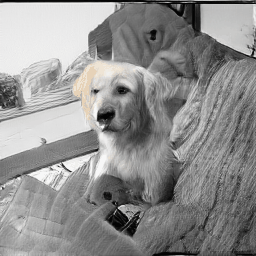

In [34]:
import imageio
imageio.mimsave('./animation.gif', images[1:])
with open('./animation.gif','rb') as f:
    display.display(display.Image(data=f.read(), height=300))